# Adding DACCS to the baseline scenario

In this tutorial, we will learn how DACCS is added as a technology in the baseline scenario. For this tutorial to run properly, you have to previously be able to run the `GENIE_sandbox_daccstest` model with `baseline` scenario. 

Similar to the previous tutorial, we firstly need to import all the required tools we need, including the `add_dac` tool.

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

import warnings
warnings.filterwarnings('ignore')

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df

from message_ix.tools.add_dac import add_dac
from message_ix.tools.add_dac import get_report

%matplotlib inline

mp = ixmp.Platform()

<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In this part, we will build a new scenario by first copying the baseline scenario we created in the previous tutorial as the `base` scenario. We will call the new scenario `scen` as the `daccs_baseline`

In [2]:
base = message_ix.Scenario(mp, model='GENIE_sandbox_daccstest', scenario="nodaccs_baseline")

scen = base.clone(
    "GENIE_sandbox_daccstest",
    "daccs_baseline",
    "adding daccs as a new technology using add_dac", 
    keep_solution=False, 
)
scen.check_out()

year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")

## Adding DACCS to the scenario using `add_dac` tool
In the `westeros` tutorial, you have learned how to add technology parameters, such as investment cost, technical lifetime, etc., into a model by using `add_par`.

This `add_dac` tool does the same thing. But, instead of adding the parameters one by one, this tool adds all DACCS parameters at once. What you need to do here is just type `add_dac(scenario,pathfile)` and include the scenario object in the parenthesis. This tool takes 2 arguments: 1) scenario object and 2) location of DACCS data set you want to include. The default location for DACCS parameters data is `~/message_ix/messae_ix/tools/add_dac/DAC_all_data.yaml`. 

In [3]:
# add daccs
filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/data/tech_data.yaml'
add_dac(scen,filepath=filepath)

Now let's remove some parameters that are not needed. In our implementation, CO2 transmission and distribution technology `dacco2_tr_dis` is simply implemented as a technology with variable cost. We assumed that someone installed the infrastructure and we just need to pay for the transmission and disposal/storage fee. Hence, `year_vtg` should be equal to `year_act`

In [4]:
# removing some parameters
pars2remove = ['emission_factor','capacity_factor','var_cost','output']
for par in pars2remove:
    df = scen.par(par,{'technology':'dacco2_tr_dis'})
    df= df.loc[df['year_vtg'] != df['year_act']]
    scen.remove_par(par, df)

# removing excess year_act
pars2remove = ['capacity_factor','fix_cost','input']
techs = ['lt_daccs', 'ht_daccs']
for par in pars2remove:
    df = scen.par(par,{'technology':techs})
    df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
    scen.remove_par(par, df)

## Run the model

In [5]:
scen.commit(comment="Add DACCS to baseline scenario")
scen.set_as_default()
scen.solve(solve_options={'barcrossalg': '2','scaind':'1'})
scen.var("OBJ")["lvl"]

3104155.5

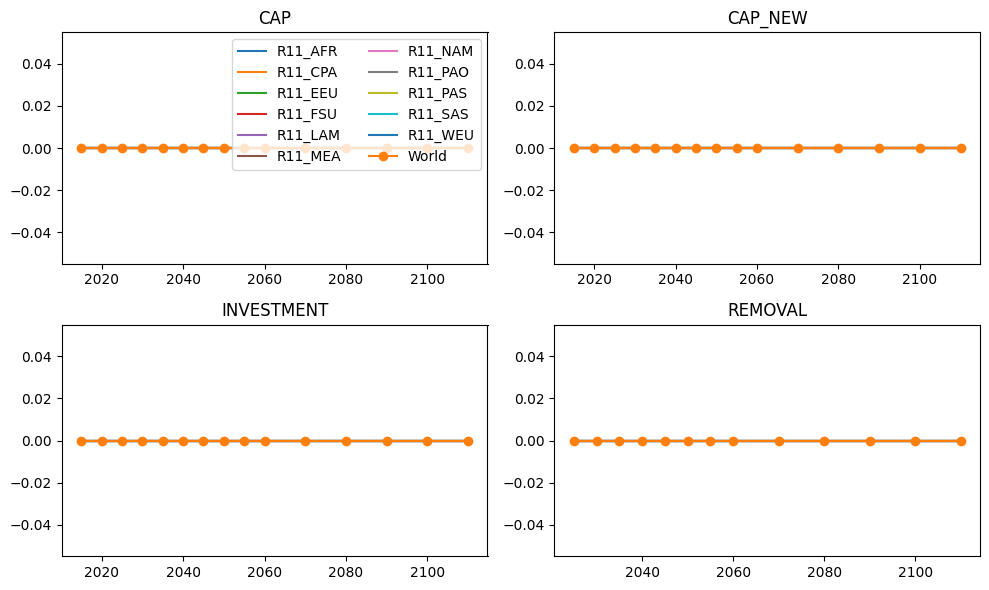

In [6]:
# Create list of technologies for get_report()
daccs_tec = ['lt_daccs','ht_daccs']

# This is how you get the report
scenario_report = get_report(scen,daccs_tec)

## Close connection

In [7]:
mp.close_db()